# **DATASET AND LIBRARY IMPORTS**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib_inline
import matplotlib.pyplot as plt
import xgboost as xgb
import ydata_profiling

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle

c:\Users\fejab\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

-----------------------

# **EXPLORATORY DATA ANALYSIS**

The ydata profiling tool is such a cool library that can give us amazing insights from our data. \
Since the train and test have the same kind of data (only difference is the Attrition column)

The main drawback of pandas/ydata profiling is its use with large datasets. With the increase in data size, the time to generate the report also increases significantly.

In [14]:
prof = ydata_profiling.ProfileReport(train)
prof.to_file(output_file='submission_group_2_profiling_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 27.87it/s]


Well, first, lets check the info about our train and test sets.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [4]:
train.describe()

,id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,838.000000,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,...,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,484.252517,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,...,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,0.000000,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.000000,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,838.000000,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,...,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,1257.000000,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,...,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,1676.000000,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,...,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1119 non-null   int64 
 1   Age                       1119 non-null   int64 
 2   BusinessTravel            1119 non-null   object
 3   DailyRate                 1119 non-null   int64 
 4   Department                1119 non-null   object
 5   DistanceFromHome          1119 non-null   int64 
 6   Education                 1119 non-null   int64 
 7   EducationField            1119 non-null   object
 8   EmployeeCount             1119 non-null   int64 
 9   EnvironmentSatisfaction   1119 non-null   int64 
 10  Gender                    1119 non-null   object
 11  HourlyRate                1119 non-null   int64 
 12  JobInvolvement            1119 non-null   int64 
 13  JobLevel                  1119 non-null   int64 
 14  JobRole                 

Okay, seems pretty straightforward. The only difference between the train and test sets is the Attrtion column. Apparently, the idea of these 2 sets is to train on the train set and then make predictions using the test set, then upload to Kaggle to check our score.

**Checking for null values**

In [6]:
train.isna().sum()

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

In [7]:
test.isna().sum()

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

Okay, we completely have no null values. That is some good news since we dont have to deal with them

**Value distribution for the `Attrition` column**

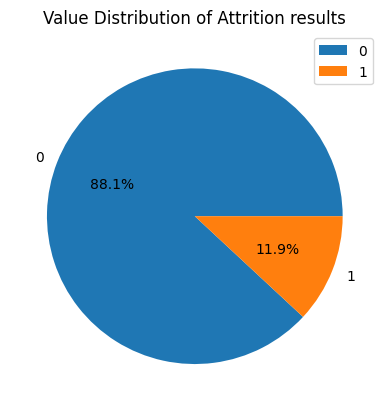

In [8]:
# Create a pie chart with percentage values
labels = train["Attrition"].value_counts().index.tolist()
sizes = train["Attrition"].value_counts().tolist()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Add a title and labels
plt.title("Value Distribution of Attrition results")
plt.legend(labels, loc="best")

# Show the chart
plt.show()

Seems like we have a highly `imbalanced` dataset. That means that the quantity of values for one category is way bigger than the other.

Lets check the categorical columns, since theyre a bit harder to understand than numerical ones.

In [9]:
categorical_variables = train.select_dtypes(include=['object'])
categorical_variables.head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,Y,Yes
1,Travel_Rarely,Sales,Other,Male,Sales Representative,Married,Y,No
2,Travel_Rarely,Sales,Marketing,Male,Sales Executive,Divorced,Y,No
3,Travel_Rarely,Research & Development,Medical,Female,Healthcare Representative,Married,Y,No
4,Travel_Rarely,Research & Development,Medical,Female,Manager,Single,Y,Yes


**Checking the distribution of the categorical variables**

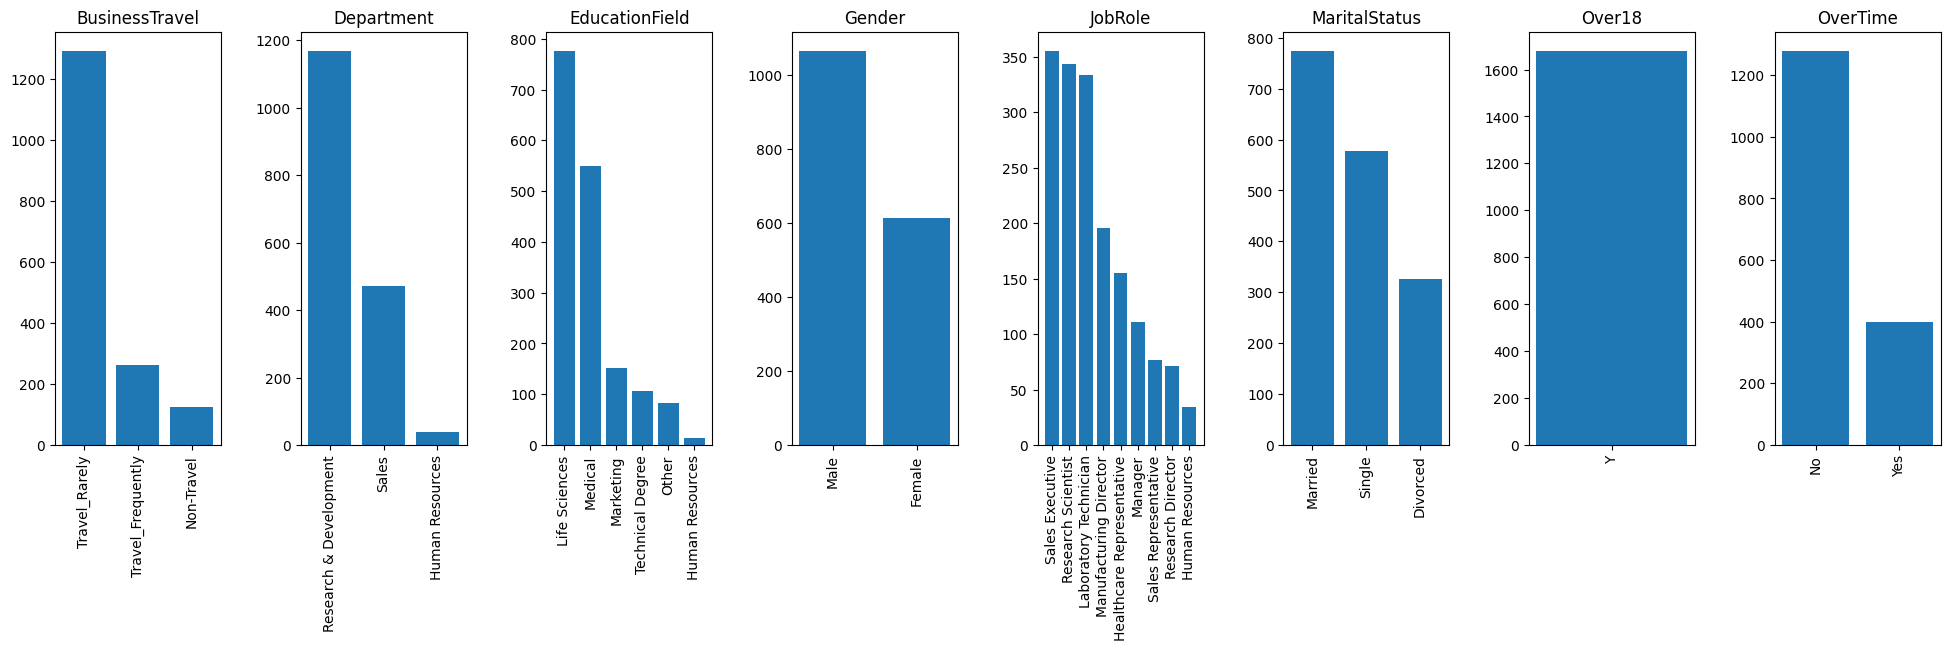

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_variables.columns), figsize=(20, 7))

# plot bar plots for each column
for i, col in enumerate(categorical_variables.columns):
    counts = categorical_variables[col].value_counts()
    axes[i].bar(counts.index, counts.values)
    axes[i].set_title(col)
    plt.setp(axes[i].get_xticklabels(), rotation=90)

plt.tight_layout(pad=2.5)
plt.show()

**Checking the distribution of the numerical variables**

In [11]:
# As checked previously we only have int64 as numerical dtype

numerical_variables = train.select_dtypes(include=['int64'])
numerical_variables.head()

,id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,599,24,3,1,4,42,3,1,...,80,1,10,2,3,10,0,7,8,0
1,1,35,921,8,3,1,1,46,3,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,718,26,3,1,3,80,3,2,...,80,2,4,3,3,3,2,1,2,0
3,3,38,1488,2,3,1,3,40,3,2,...,80,0,15,1,1,6,0,0,2,0
4,4,50,1017,5,4,1,2,37,3,5,...,80,0,31,0,3,31,14,4,10,1


,id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,838.000000,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,...,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,484.252517,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,...,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,0.000000,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.000000,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,838.000000,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,...,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,1257.000000,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,...,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,1676.000000,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,...,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


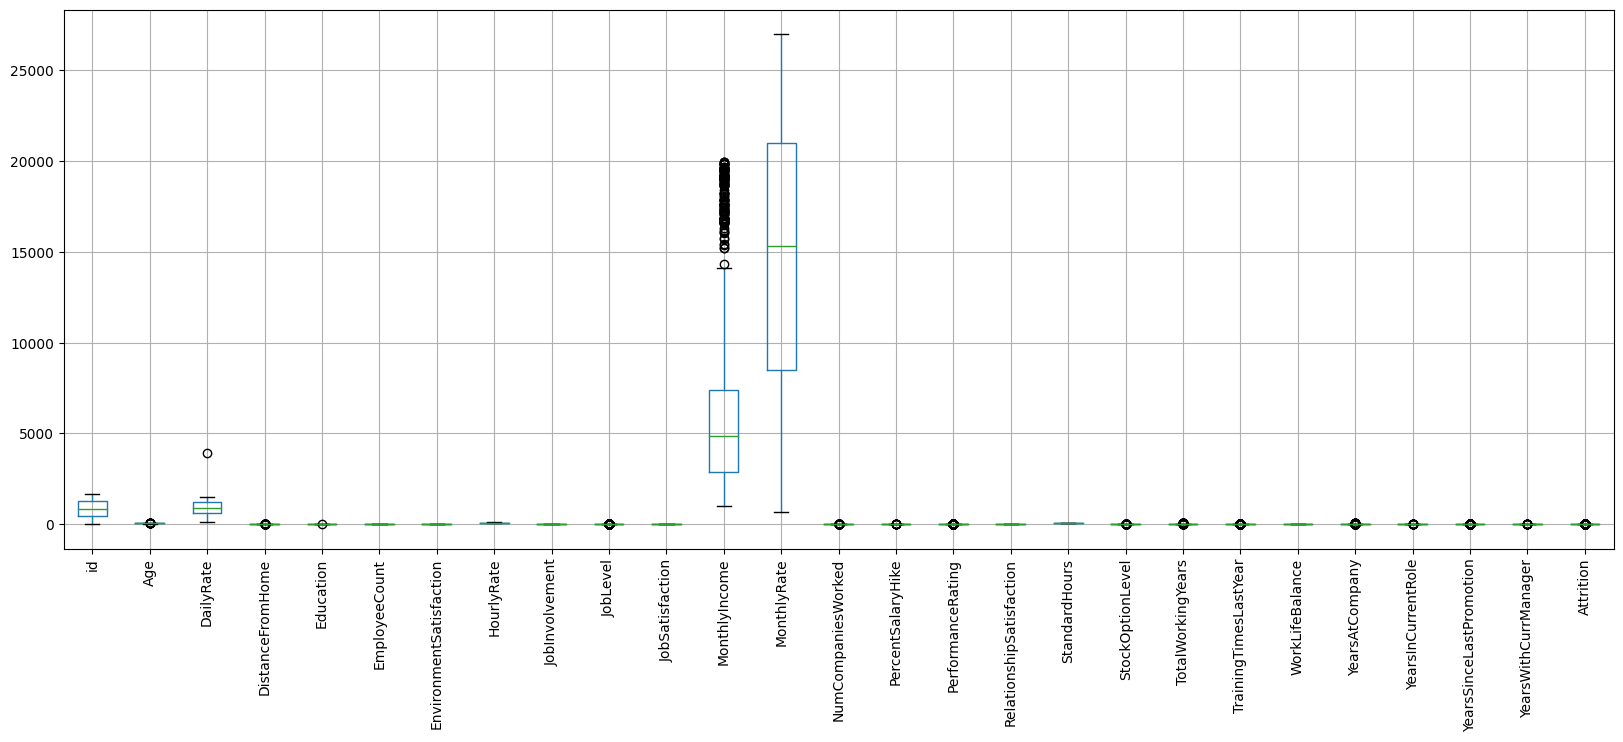

In [12]:
summary = numerical_variables.describe()
display(summary)

# create boxplots to visualize the distribution of each variable
fig, ax = plt.subplots(figsize=(20,7))
numerical_variables.boxplot(ax=ax)
plt.xticks(rotation=90)
plt.show()

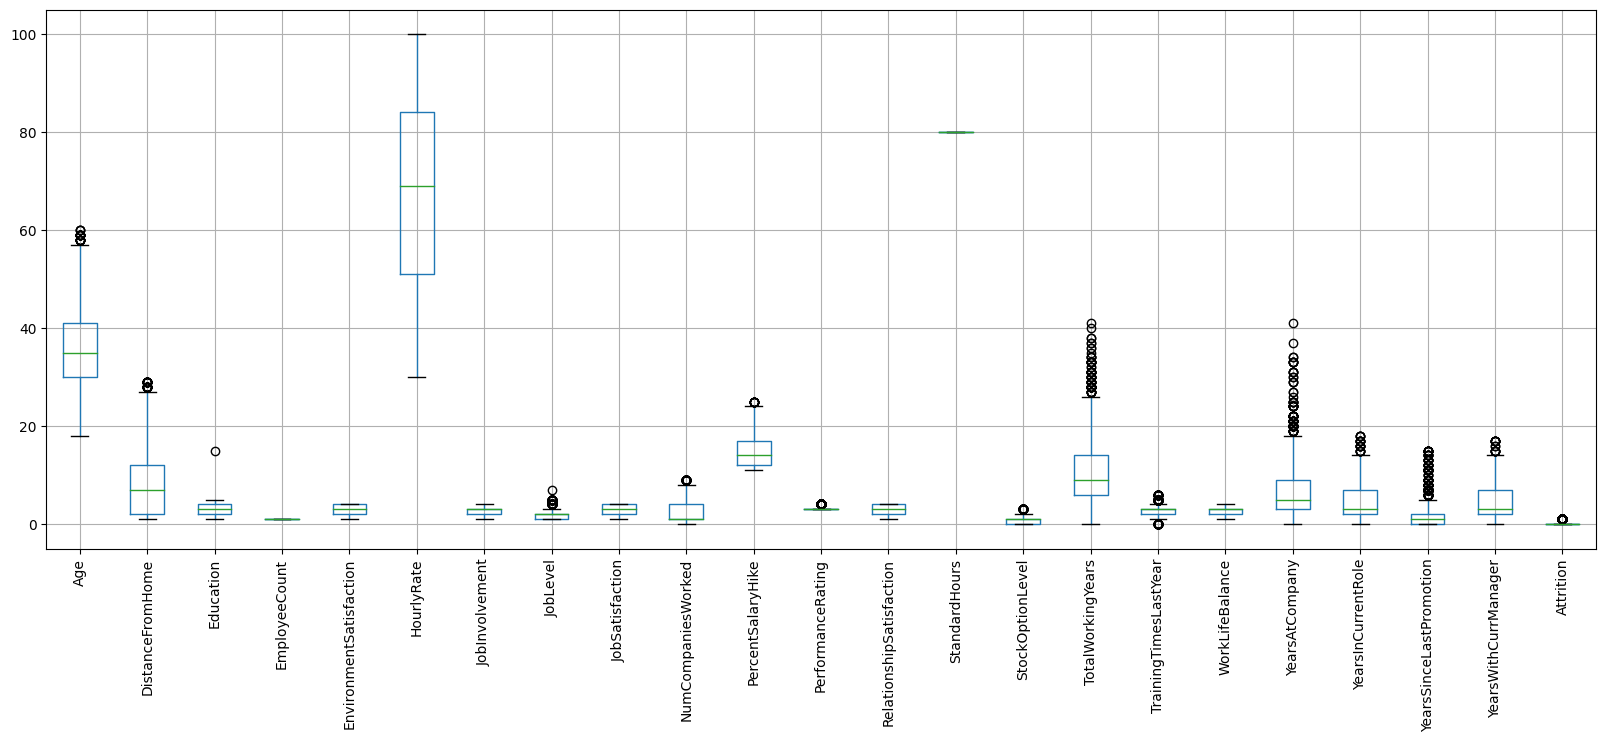

In [13]:
new_numerical_variables = numerical_variables.drop(["id","DailyRate","MonthlyIncome", "MonthlyRate"], axis=1)

fig, ax = plt.subplots(figsize=(20,7))
new_numerical_variables.boxplot(ax=ax)
plt.xticks(rotation=90)
plt.show()

----------------------------------------

# **FEATURE ENGINEERING**

**REMOVING ROWS WITH JUST ONE VALUE**

In [14]:
train.nunique().sort_values()

StandardHours                  1
EmployeeCount                  1
Over18                         1
Attrition                      2
PerformanceRating              2
OverTime                       2
Gender                         2
BusinessTravel                 3
Department                     3
MaritalStatus                  3
WorkLifeBalance                4
StockOptionLevel               4
RelationshipSatisfaction       4
JobSatisfaction                4
JobInvolvement                 4
EnvironmentSatisfaction        4
Education                      6
EducationField                 6
JobLevel                       6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                34
TotalWorkingYears             41
Age                           43
HourlyRate

In [15]:
train["Over18"].value_counts()

Y    1677
Name: Over18, dtype: int64

In [16]:
train["EmployeeCount"].value_counts()

1    1677
Name: EmployeeCount, dtype: int64

In [17]:
train["StandardHours"].value_counts()

80    1677
Name: StandardHours, dtype: int64

All employees in the company are over the age of 18. So we do not need this information. Same with the `EmployeeCount` and `StandardHours` columns.

In [18]:
for col in train.columns:
    if train[col].nunique() == 1:
        train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

In [19]:
train.shape[1]

32

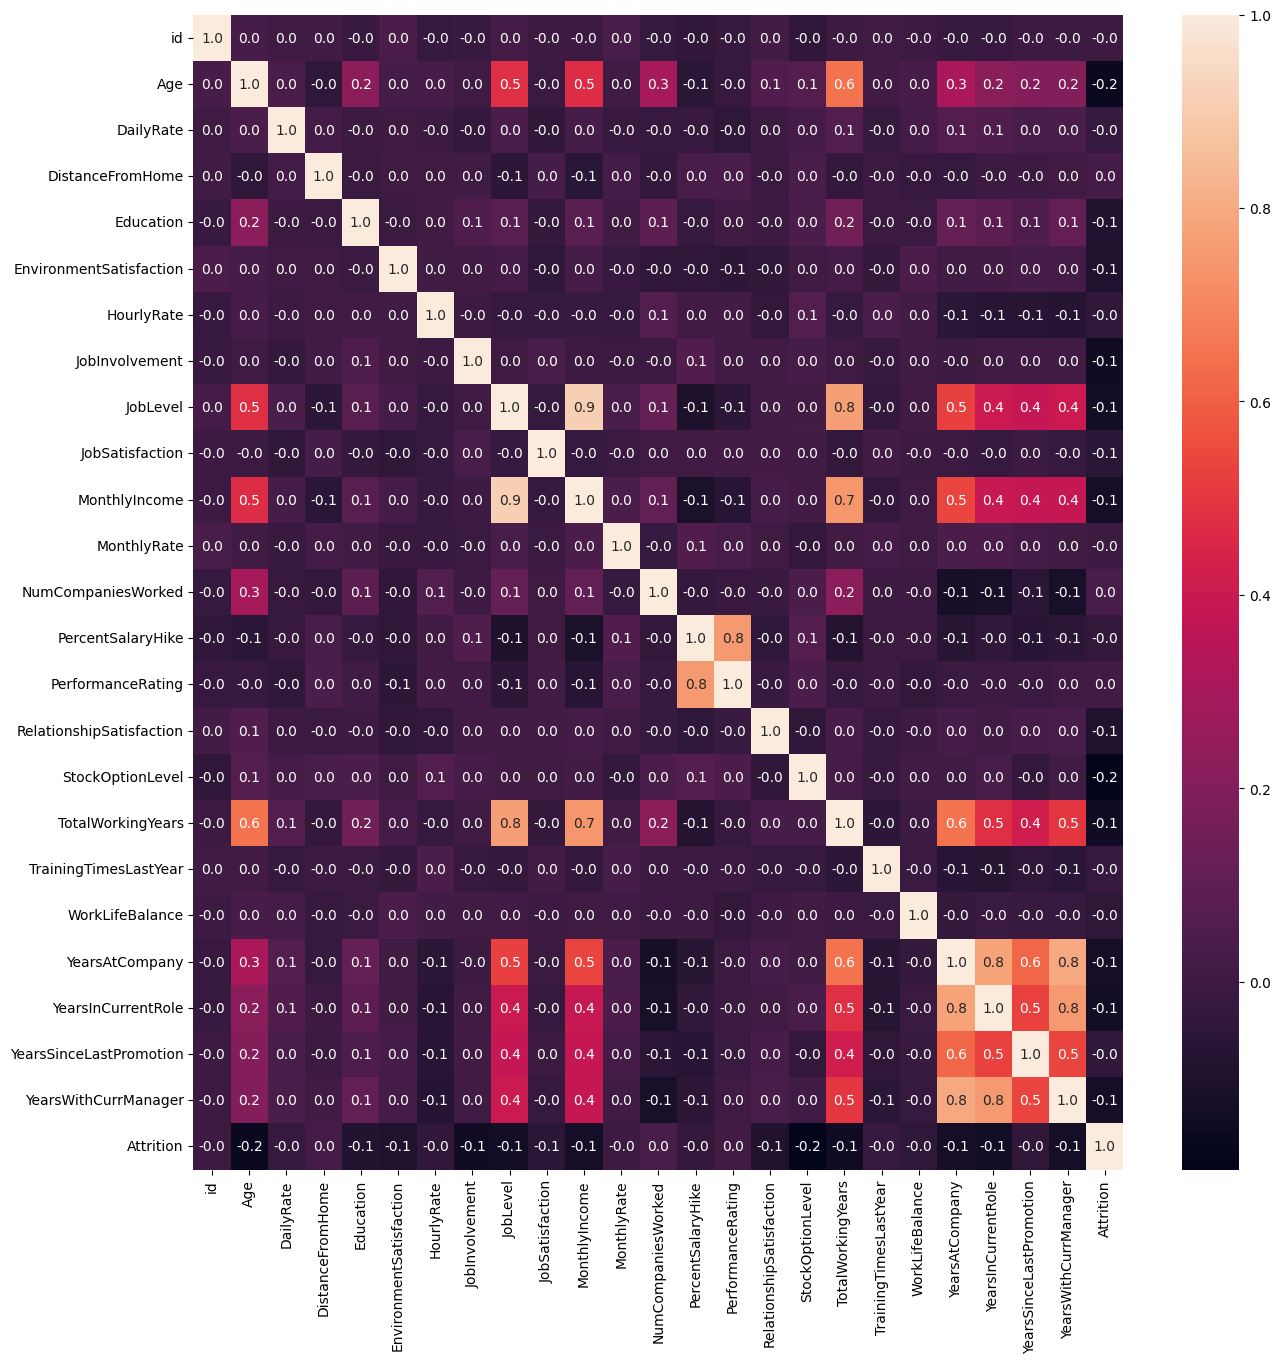

In [20]:
# Plotting correlation between the variables

corr = train.corr(numeric_only=True)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt= ".1f")
plt.show()

**MOST CORRELATED COLUMNS:**
- Job Role & Department
- Monthly Income & Job Level
- Total Working Years & Job Level
- Performance rating & Percent Salary Hike
- Years at Company & Years at Current Role & Years with Current Manager

### **CREATING NEW COLUMNS**

**AGE GROUP COLUMN**

In [21]:
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70']

train['Age_group'] = pd.cut(train['Age'], bins=bins, labels=labels, include_lowest=True)
test['Age_group'] = pd.cut(test['Age'], bins=bins, labels=labels, include_lowest=True)


train[['Age', 'Age_group']].head()

,Age,Age_group
0,36,31-40
1,35,31-40
2,32,31-40
3,38,31-40
4,50,41-50


**DISTANCE CATEGORY COLUMN**

In [22]:
bins = [-1, 5, 10, 1000]
labels = ['Short', 'Medium', 'Long']

train['Distance_category'] = pd.cut(train['DistanceFromHome'], bins=bins, labels=labels, include_lowest=True)
test['Distance_category'] = pd.cut(test['DistanceFromHome'], bins=bins, labels=labels, include_lowest=True)


train[['DistanceFromHome', 'Distance_category']].head()

,DistanceFromHome,Distance_category
0,24,Long
1,8,Medium
2,26,Long
3,2,Short
4,5,Short


**SATISFACTION LEVEL COLUMN**

In [23]:
train['Satisfaction_level'] = train['EnvironmentSatisfaction'] + train["RelationshipSatisfaction"]
test['Satisfaction_level'] = test['EnvironmentSatisfaction'] + test["RelationshipSatisfaction"]


train[['Satisfaction_level', 'EnvironmentSatisfaction','RelationshipSatisfaction']]

,Satisfaction_level,EnvironmentSatisfaction,RelationshipSatisfaction
0,6,4,2
1,5,1,4
2,7,3,4
3,6,3,3
4,5,2,3
...,...,...,...
1672,6,4,2
1673,5,1,4
1674,5,2,3
1675,5,2,3


**JOB TITLE COLUMN**

In [24]:
train['Job_Title'] = train['JobRole'] + ' - ' + train['Department']
test['Job_Title'] = test['JobRole'] + ' - ' + test['Department']


train['Job_Title'].value_counts()

Sales Executive - Sales                               355
Research Scientist - Research & Development           344
Laboratory Technician - Research & Development        334
Manufacturing Director - Research & Development       196
Healthcare Representative - Research & Development    155
Sales Representative - Sales                           77
Research Director - Research & Development             71
Manager - Research & Development                       66
Manager - Sales                                        39
Human Resources - Human Resources                      33
Manager - Human Resources                               6
Human Resources - Research & Development                1
Name: Job_Title, dtype: int64

**EXPERIENCE FACTOR**

In [25]:
train['Experience_factor'] = train['TotalWorkingYears'] * train['JobLevel']
test['Experience_factor'] = test['TotalWorkingYears'] * test['JobLevel']

train[['Experience_factor', 'TotalWorkingYears', 'JobLevel']]

,Experience_factor,TotalWorkingYears,JobLevel
0,10,10,1
1,4,4,1
2,8,4,2
3,30,15,2
4,155,31,5
...,...,...,...
1672,30,10,3
1673,10,10,1
1674,1,1,1
1675,20,10,2


**DROPPING THE ALREADY USED COLUMNS**

In [26]:
train.drop(['EnvironmentSatisfaction',"RelationshipSatisfaction",'JobRole', "Age", "DistanceFromHome", 'Department',"JobLevel","TotalWorkingYears"], axis=1, inplace=True)
test.drop(['EnvironmentSatisfaction',"RelationshipSatisfaction",'JobRole',"Age", "DistanceFromHome",'Department',"JobLevel","TotalWorkingYears"], axis=1, inplace=True)

**DROPPING OTHER COLUMNS THAT ARE SUPER CORRELATED**

**MOST CORRELATED COLUMNS:**
- Stock Option Level & Marital Status
- Years at Company & Years at Current Role & Years with Current Manager

In [27]:
train.drop(["StockOptionLevel","YearsInCurrentRole","YearsWithCurrManager","YearsSinceLastPromotion", "MonthlyIncome", "PercentSalaryHike"], axis=1, inplace=True)
test.drop(["StockOptionLevel","YearsInCurrentRole","YearsWithCurrManager","YearsSinceLastPromotion", "MonthlyIncome", "PercentSalaryHike"], axis=1, inplace=True)

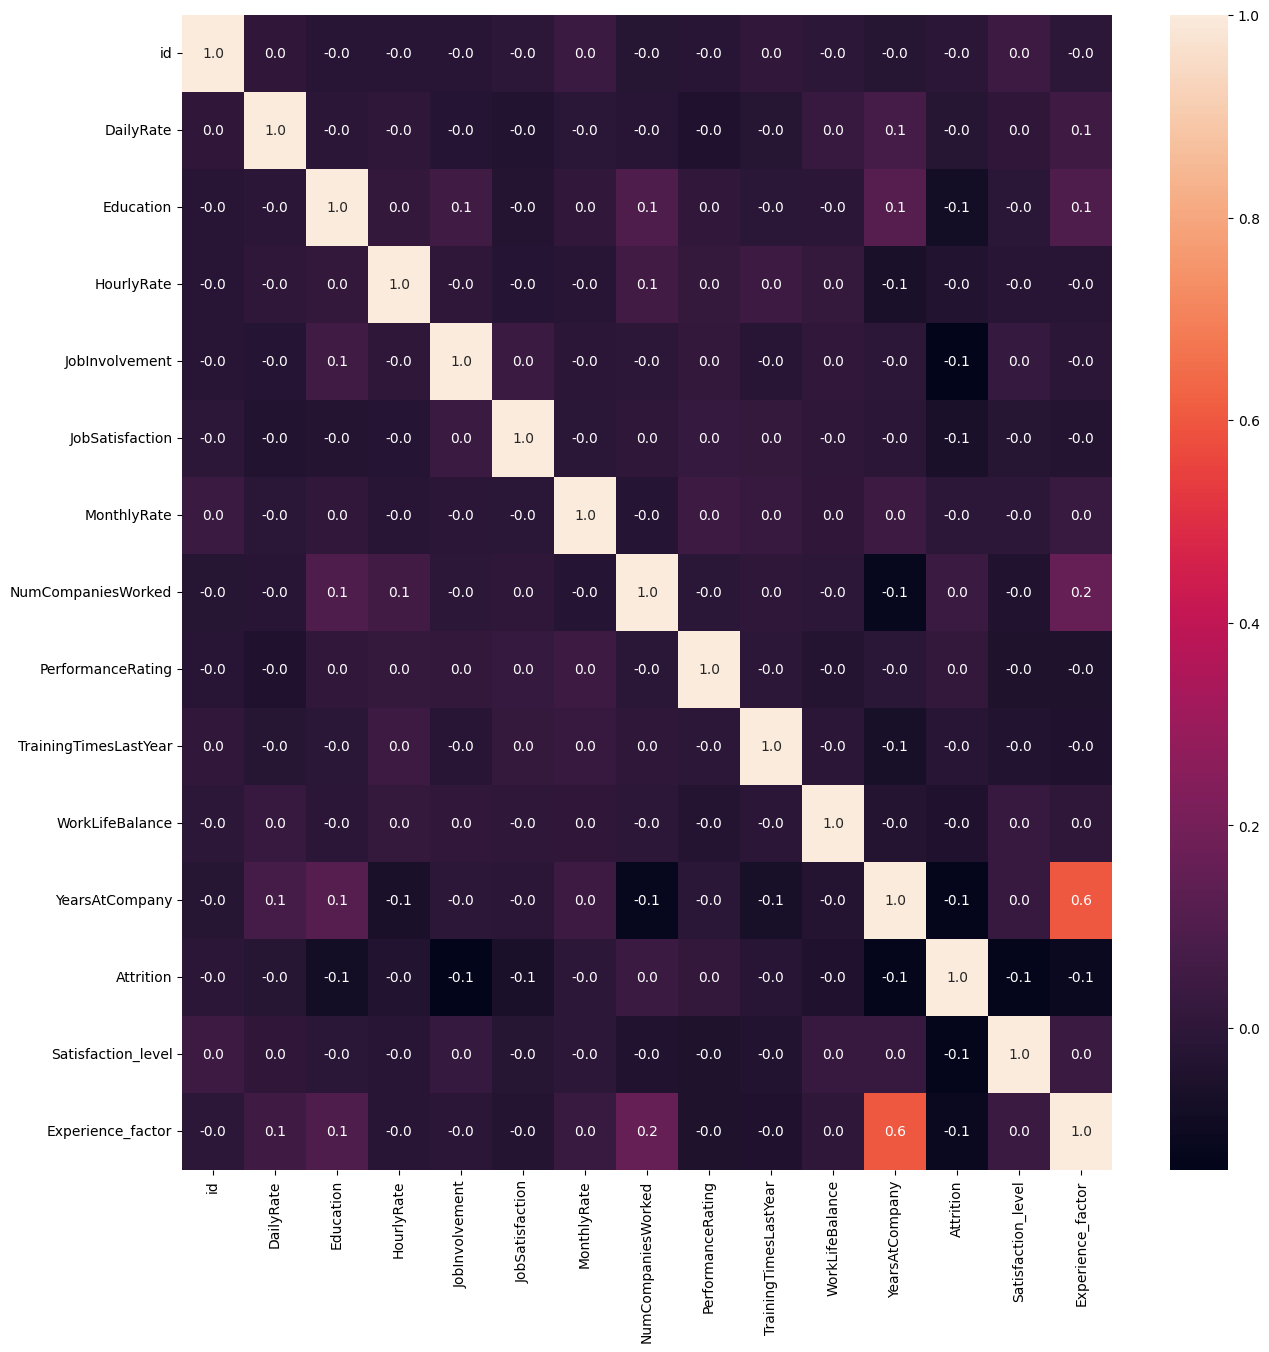

In [28]:
# Plotting correlation between the variables

corr = train.corr(numeric_only=True)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt= ".1f")
plt.show()

**LABEL ENCONDING**

In [29]:
# Define the columns to be encoded
cat_columns = ['BusinessTravel', 'EducationField', 'Gender', 'MaritalStatus', "Age_group", "Distance_category", "OverTime","Job_Title"]

# Apply label encoding to train and test dataframes
for col in cat_columns:
    le = LabelEncoder()
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

-----------------------------

# **MACHINE LEARNING MODELS**

Okay. Just for reference and to start with, lets try running a basic and simple Random Forest, a xgboost classifier and a logistic regression on all of our data.

In [141]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(["Attrition"], axis=1), train["Attrition"], test_size=0.2)

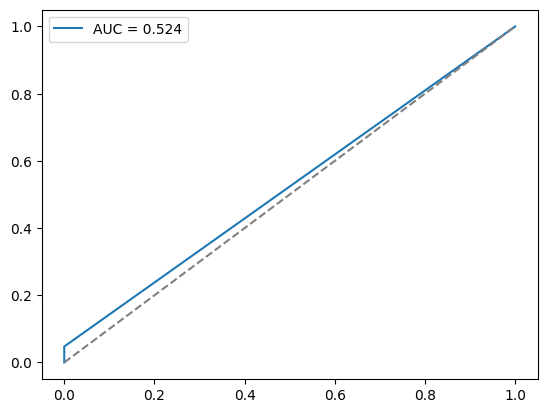

In [142]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

# Calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict(X_test))
auc = roc_auc_score(y_test, rfc.predict(X_test))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend()
plt.show()

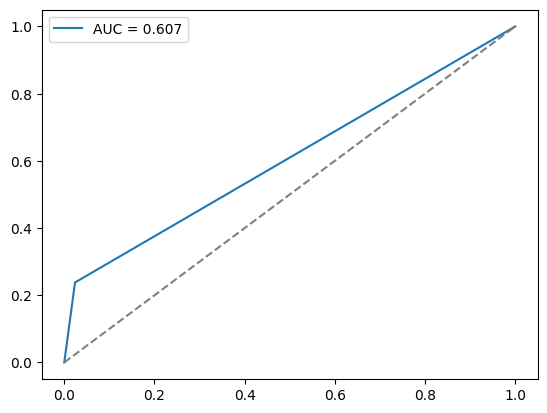

In [143]:
clf = xgb.XGBClassifier()
clf.fit(X_train,y_train)
score_xgb = roc_auc_score(y_test, clf.predict(X_test))

# Calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend()
plt.show()

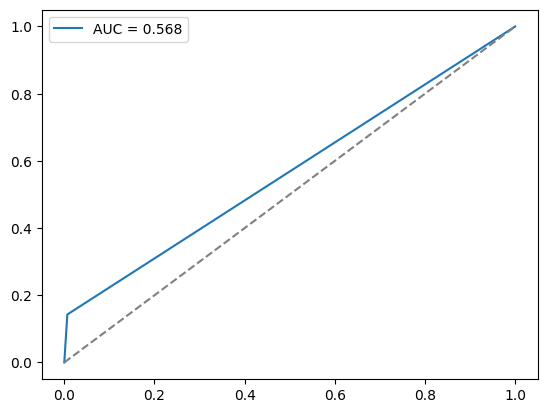

In [144]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log = LogisticRegression()
log.fit(X_train_scaled, y_train)
score_log = roc_auc_score(y_test, log.predict(X_test_scaled))

# Calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, log.predict(X_test_scaled))
auc = roc_auc_score(y_test, log.predict(X_test_scaled))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend()
plt.show()

______________________________________________________________________________________

**CREATING THE DATA SETS**

These low scores might be due to the imbalanced nature of the dataset. We have around ten employees that don't leave per one that leaves. \
We are going to use a technique to solve this issue called Iterative sampling.

In [145]:
train[train["Attrition"] == 1]

,id,BusinessTravel,DailyRate,Education,EducationField,Gender,HourlyRate,JobInvolvement,JobSatisfaction,MaritalStatus,...,PerformanceRating,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,Attrition,Age_group,Distance_category,Satisfaction_level,Job_Title,Experience_factor
4,4,2,1017,4,3,0,37,3,1,2,...,3,0,3,31,1,2,2,5,5,155
24,24,1,746,3,1,0,62,4,2,2,...,3,2,2,5,1,0,0,6,10,10
40,40,2,833,3,3,0,78,2,3,1,...,4,3,2,1,1,0,1,7,3,1
43,43,2,469,3,2,1,56,1,3,1,...,4,2,3,0,1,1,2,2,11,4
47,47,2,119,3,4,1,93,3,4,0,...,3,2,2,10,1,0,0,6,8,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,1613,2,1151,1,2,0,82,3,1,2,...,3,4,2,6,1,0,1,6,10,12
1614,1614,1,1329,4,3,1,49,3,2,1,...,3,2,3,2,1,1,1,5,3,7
1638,1638,1,240,1,3,1,43,2,4,2,...,3,2,3,10,1,1,2,4,3,20
1642,1642,2,1174,3,3,1,42,3,1,1,...,3,4,3,1,1,1,2,4,3,14


We only have the info about around 200 employees who left. Which leaves us with not many data to input our model and make it able to predict a 1 correctly. \
Lets create a dataframe that contains only rows with a 1 in the "Attrition" column

In [146]:
ones = train[train["Attrition"] == 1].copy() #.copy() avoids warnings and makes the code more robust.

Okay, what we want to do now is to get a similar amount of employees who did not leave the company.

In [147]:
zeros = train[train["Attrition"] == 0].copy()

______________________________________________________________________________________

**VALIDATION SET**

By the looks of the zeros dataframe, we are able to know that there are 77 rows that are not going to be used (see iteration + explanation below). So lets create an extra test/validation dataframe with a sample of some 1s to check our roc aucs and be able to plot the curve. 

In [148]:
zeros.shape

(1477, 23)

This is because we will take samples of 200 rows from our zeros df. When there are not enough rows in that dataframe, the loop will stop. So something like this will happen:
- 1st Iteration: 1477 rows
- 2nd Iteration: 1277 rows
- 3rd Iteration: 1077 rows
- 4th Iteration: 877 rows
- 5th Iteration: 677 rows
- 6th Iteration: 477 rows
- 7th Iteration: 277 rows
- 8th Iteration: 77 rows  ---------> *Stop*

We will create below the validation set mentioned, combining 77 random rows with `Attrition` = 0, and 77 random rows with `Attrition` = 1

In [149]:
zeros_model = zeros.copy()

zeros_sample_validation = zeros_model.sample(77) #picking 77 rows from 0s dataset
ones_sample_validation = ones.sample(77) #picking 77 rows from 1s dataset

zeros_model.drop(zeros_sample_validation.index, inplace = True) #removing 0s for validation set from our zeros_model df

validation_df = pd.concat([zeros_sample_validation,ones_sample_validation]) #Merging dataset
validation_df = shuffle(validation_df)
validation_df.shape

(154, 23)

In [150]:
zeros_model.shape

(1400, 23)

---------------------

**OUR MODELS**

Creating the dataframe where the predictiones will be stored

In [151]:
predictions_df = pd.DataFrame()

This is the search space for our ideal parameters for each model. Instead of running a GridSearch with all of our data, what we did is that the GridSearch is run for every iteration of the loop, making every prediction being done with the best possible parameters tailored to that data

In [152]:
param_grid_rfc = {
    'n_estimators' : [25, 50, 100, 150, 500],
    'max_depth' : [2, 5, 10, 50],
    'bootstrap' : [True, False],
}

param_grid_xgb = {
    'learning_rate': [0.01, 0.02, 0.05],
    'max_depth': [3, 5],
    'n_estimators': [100,200, 500],
}

Also, it is not a great idea to choose a lot of parameters if we dont exactly know what they mean, in a lot of cases is better to leave the not-so-important parameters as default.

-----------------------------

This technique was used by the team "Carbon Cutters" in the 2023 ie Sustainability Datathon. Its name is **iterative sampling**.


The aim of the approach is to mitigate the impact of imbalanced classes by creating a training set that contains an equal number of samples from the majority class and the minority class. To achieve this, the approach randomly selects a subset of the majority class that is equivalent in size to the minority class. The following steps outline how the code executes this approach:

- The size of the minority class is determined by calculating the length of the `ones` variable, which is used as a reference to set the desired size of each training set.
- A copy of the training data that contains only samples from the minority class is created and stored in the `model_zeros` variable.
- A dataframe is created to hold the predictions generated by the classifier both for kaggle and validation.
- A loop is initialized to run until the `zeros` dataset has less elements than the `ones` dataset.
- GridSearchCV + Training + Scoring + Predicting is performed
- The loop starts again.

The final mean ROC AUC score is calculated by averaging the ROC AUC scores generated from all the iterations.

<p align="center">
  <img src="https://i.imgur.com/fY6714S.png" width="800"/>
</p>

**RANDOM FOREST MODEL**

In [153]:
i = 0 
mean_roc = 0
rfc_validation = pd.DataFrame()
 
while len(zeros_model) >= len(ones):
    
    print(f"Iteration {i+1}:")
    
    # Iterating on the zeroes
    zeros_sampled = zeros_model.sample(n=len(ones))
    zeros_model.drop(zeros_sampled.index, inplace = True)
    
    # Our data to use
    model_df = pd.concat([ones, zeros_sampled])
    model_df = shuffle(model_df)
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(model_df.drop(["Attrition"], axis=1), model_df["Attrition"], test_size=0.1)
    
    # Creating, tuning and and fitting the classifier
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid_rfc, cv = 3, scoring = "roc_auc", n_jobs=-1)    
    grid_search.fit(X_train, y_train)


    clf = RandomForestClassifier(**grid_search.best_params_)
    clf.fit(X_train, y_train)

    # Scoring our model
    score = roc_auc_score(y_test, clf.predict(X_test))
    print(f"ROC AUC SCORE: {score} \n")
    mean_roc += score
    i = i+1
    
    # Predicting on the Kaggle test dataset
    y_pred = clf.predict(test)
    predictions_df[f"rfc run{i}"] = y_pred
    
    
    # Creating the predicting test dataframe
    y_pred_val = clf.predict(validation_df.drop(["Attrition"], axis=1))
    rfc_validation[f"rfc_run{i}"] = y_pred_val


print(f"The final mean ROC AUC is: {mean_roc/(i)}")

Iteration 1:
ROC AUC SCORE: 0.7133333333333333 

Iteration 2:
ROC AUC SCORE: 0.7493734335839599 

Iteration 3:
ROC AUC SCORE: 0.625 

Iteration 4:
ROC AUC SCORE: 0.6342710997442454 

Iteration 5:
ROC AUC SCORE: 0.7200000000000002 

Iteration 6:
ROC AUC SCORE: 0.8358585858585859 

Iteration 7:
ROC AUC SCORE: 0.7525252525252525 

The final mean ROC AUC is: 0.7186231007207681


**XGBOOST MODEL**

In [154]:
i = 0 
mean_roc = 0
zeros_model = zeros.copy()
predictions_df2 = pd.DataFrame()
xgb_validation = pd.DataFrame()
 
while len(zeros_model) >= len(ones):
    
    print(f"Iteration {i+1}:")
    
    # Iterating on the zeroes
    zeros_sampled = zeros_model.sample(n=len(ones))
    zeros_model.drop(zeros_sampled.index, inplace = True)
    
    # Our data to use
    model_df = pd.concat([ones, zeros_sampled])
    model_df = shuffle(model_df)
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(model_df.drop(["Attrition"], axis=1), model_df["Attrition"], test_size=0.1)
    
    # Creating and fitting the classifier
    xgboost = xgb.XGBClassifier()
    grid_search2 = GridSearchCV(estimator = xgboost, param_grid = param_grid_xgb, cv = 3, scoring = "roc_auc", n_jobs=-1)    
    grid_search2.fit(X_train, y_train)
    
    
    clf = xgb.XGBClassifier(**grid_search2.best_params_)
    clf.fit(X_train, y_train)

    # Scoring our model
    score = roc_auc_score(y_test, clf.predict(X_test))
    print(f"ROC AUC SCORE: {score} \n")
    mean_roc += score
    i = i+1
    
    # Predicting on the Kaggle test dataset
    y_pred = clf.predict(test)
    predictions_df[f"xgb run{i}"] = y_pred
    
    # Creating the predicting test dataframe
    y_pred_val = clf.predict(validation_df.drop(["Attrition"], axis=1))
    xgb_validation[f"xgb_run{i}"] = y_pred_val

print(f"The final mean ROC AUC is: {mean_roc/(i)}")

Iteration 1:
ROC AUC SCORE: 0.7442455242966751 

Iteration 2:
ROC AUC SCORE: 0.7250000000000001 

Iteration 3:
ROC AUC SCORE: 0.5732323232323233 

Iteration 4:
ROC AUC SCORE: 0.7 

Iteration 5:
ROC AUC SCORE: 0.6399999999999999 

Iteration 6:
ROC AUC SCORE: 0.6867007672634271 

Iteration 7:
ROC AUC SCORE: 0.6649616368286445 

The final mean ROC AUC is: 0.6763057502315816


These tests are really misleading, since they use a tiny little test size. So take them with a pinch of salt

**PREDICTIONS DATAFRAME**

As we can see, we have 14 different predictions on the kaggle set, with 7 iterations per model on 7 different splits of our data. We are now basically going to shrink it down to just one column, making the most predicted class for each employee being used.

In [156]:
predictions_df

,rfc run1,rfc run2,rfc run3,rfc run4,rfc run5,rfc run6,rfc run7,xgb run1,xgb run2,xgb run3,xgb run4,xgb run5,xgb run6,xgb run7
0,1,1,1,1,0,1,1,1,1,1,1,0,1,1
1,0,1,0,1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,1,0,0,0,0,1,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,1,1,1,1,0,1,1,1,1,1,0,0,0,1
1115,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1116,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1117,0,0,0,0,0,0,0,0,0,0,0,0,0,0


So, in this case, employee 0 will have a value of Attrition 1. \
Employee 1 will have a predicted Attrition of 0 (3 ones and 11 zeros)

**VALIDATION DATAFRAME**

In our loop, we also predicted with the models we trained on a validation dataframe, for us to be able to plot the ROC AUC curve and score our model locally.

In [157]:
val_predictions = pd.concat([rfc_validation,xgb_validation],axis=1)
val_predictions = val_predictions.mean(axis=1)
val_predictions = round(val_predictions)
val_predictions

0      1.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
149    0.0
150    0.0
151    1.0
152    1.0
153    0.0
Length: 154, dtype: float64

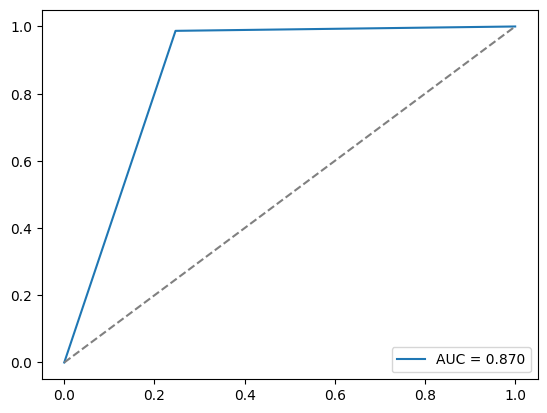

In [158]:
# Calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(validation_df["Attrition"], val_predictions)
auc = roc_auc_score(validation_df["Attrition"], val_predictions)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend()
plt.show()

Score is a little too high due to overfitting on the 77 ones we used both on train and val

**CALCULATING THE MEAN PREDICTED VALUE FOR EACH EMPLOYEE, THEN WE ROUND IT TO A BINARY VALUE (KAGGLE DATASET)**

We were playing around with different thresholds, but the default one (0.5) seems to be the one that works best.

In [159]:
mean_predictions = predictions_df.mean(axis=1)
result_df = pd.DataFrame({'id': test["id"], 'Attrition': mean_predictions})

result_df['Attrition'] = round(result_df['Attrition'])

result_df

,id,Attrition
0,1677,1.0
1,1678,0.0
2,1679,0.0
3,1680,0.0
4,1681,1.0
...,...,...
1114,2791,1.0
1115,2792,0.0
1116,2793,0.0
1117,2794,0.0


Our dataframe is ready to be uploaded and scored to Kaggle!

In [160]:
result_df.to_csv("submission_group_2.csv", index= False)

In [30]:
train.to_csv("train_final.csv", index= False)
test.to_csv("test_final.csv", index= False)